In [78]:
# ToDo: Music vs Noise
import os
import glob
from nilearn.image import concat_imgs, index_img, resample_to_img, math_img
import pandas as pd

In [79]:
# Define paths
data_path = '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2'
fmriprep_path = os.path.join(data_path, 'derivatives', 'fmriprep23')

# subject
subject = '02'

In [80]:
# fetch functional images for subject

# Define the path to the functional images
func_path = os.path.join(fmriprep_path, f'sub-{subject}', 'ses-01', 'func', f'sub-{subject}_ses-01_task-02a_run-*_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')

# find all the files 
func_files = sorted(glob.glob(func_path))
print(func_files)

# concatenate the files
func_img = concat_imgs(func_files)


['/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/fmriprep23/sub-02/ses-01/func/sub-02_ses-01_task-02a_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/fmriprep23/sub-02/ses-01/func/sub-02_ses-01_task-02a_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/fmriprep23/sub-02/ses-01/func/sub-02_ses-01_task-02a_run-3_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/derivatives/fmriprep23/sub-02/ses-01/func/sub-02_ses-01_task-02a_run-4_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz']


In [81]:
n_volumes_run = int(func_img.shape[-1] / 4)

# define chunks based on number of volumes and considering 4 runs (1 chunk per run). the format is just the number of the run from 1 to 4
chunks = [1] * n_volumes_run + [2] * n_volumes_run + [3] * n_volumes_run + [4] * n_volumes_run
print(chunks)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [82]:
# Load events file for subject and concatenate
events_path = os.path.join(data_path, f'sub-{subject}', 'ses-01', 'func', f'sub-{subject}_ses-01_task-02a_run-*_events.tsv')
events_files = sorted(glob.glob(events_path))
print(events_files)

condition_indexes = []
condition_names = []

for jj in range(len(events_files)):
    events = pd.read_csv(events_files[jj], sep='\t')
    run_volumes = [''] * n_volumes_run

    # hemodynamic delay
    events['onset'] = events['onset'] + 4

    # round onset and durations to the nearest integer and convert to int
    events['onset'] = events['onset'].round().astype(int)
    events['duration'] = events['duration'].round().astype(int)

    # remove all noise events
    events = events[events['trial_type'] != 'Noise']
    events.reset_index(drop=True, inplace=True)

    for ii in range(events.shape[0]):
        start = events['onset'][ii]
        end = events['onset'][ii] + events['duration'][ii]
        run_volumes[start:end] = [events['trial_type'][ii]] * (end - start)
    
    for zz in range(len(run_volumes)):
        if run_volumes[zz] != '':
            condition_indexes.append(zz+jj*n_volumes_run)
            condition_names.append(run_volumes[zz])

# identify condition indexes greater than the number of volumes and remove them
condition_indexes = [x for x in condition_indexes if x < func_img.shape[-1]]
condition_names = condition_names[:len(condition_indexes)]

print(condition_indexes)
print(len(condition_indexes))
print(condition_names)
print(len(condition_names))

['/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/sub-02/ses-01/func/sub-02_ses-01_task-02a_run-1_events.tsv', '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/sub-02/ses-01/func/sub-02_ses-01_task-02a_run-2_events.tsv', '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/sub-02/ses-01/func/sub-02_ses-01_task-02a_run-3_events.tsv', '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/sub-02/ses-01/func/sub-02_ses-01_task-02a_run-4_events.tsv']
[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 20

In [83]:
# delete volumes using idx_volumes
func_img = index_img(func_img, condition_indexes)
print(func_img.shape)

(97, 115, 97, 1728)


In [84]:
# delete volumes from chunks using idx_volumes
chunks = [chunks[i] for i in condition_indexes]
chunks

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [85]:
# Load the mask image, resample it to the data's resolution, and binarize it
mask_img = os.path.join(data_path,'derivatives','mni_icbm152_t1_tal_nlin_asym_09c_mask.nii')

mask_img_resampled = resample_to_img(mask_img, func_img)

mask_img_resampled_bin = math_img('img > 0.5', img=mask_img_resampled)

In [86]:
# Obtain prediction scores via cross validation
# ---------------------------------------------
# Define the cross-validation scheme used for validation. Here we use a
# LeaveOneGroupOut cross-validation on the run group which corresponds to a
# leave a run out scheme, then pass the cross-validator object
# to the cv parameter of decoder.leave-one-session-out.
# For more details please take a look at:
# `Measuring prediction scores using cross-validation\
# <../00_tutorials/plot_decoding_tutorial.html#measuring-prediction-scores-using-cross-validation>`_
from nilearn.decoding import Decoder
from sklearn.model_selection import LeaveOneGroupOut

cv = LeaveOneGroupOut()

decoder = Decoder(
    estimator="svc",
    mask=mask_img_resampled_bin,
    standardize="zscore_sample",
    screening_percentile=5,
    scoring="accuracy",
    cv=cv,
    n_jobs=2,
)
# Compute the prediction accuracy for the different folds (i.e. run)
decoder.fit(func_img, condition_names, groups=chunks)

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 15499  15553  18204 ... 218236 218291 218346] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 15499  15553  18204 ... 218236 218291 218346] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/brainpl

In [87]:
# Print the CV scores
print(decoder.cv_scores_)

{'JoyfulActivation': [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111], 'Nostalgia': [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.11342592592592593], 'Peacefulness': [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111], 'Power': [0.1111111111111111, 0.1574074074074074, 0.1111111111111111, 0.1111111111111111], 'Sadness': [0.1111111111111111, 0.11342592592592593, 0.1111111111111111, 0.1111111111111111], 'Tenderness': [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111], 'Tension': [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111], 'Transcendence': [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111], 'Wonder': [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.11342592592592593]}


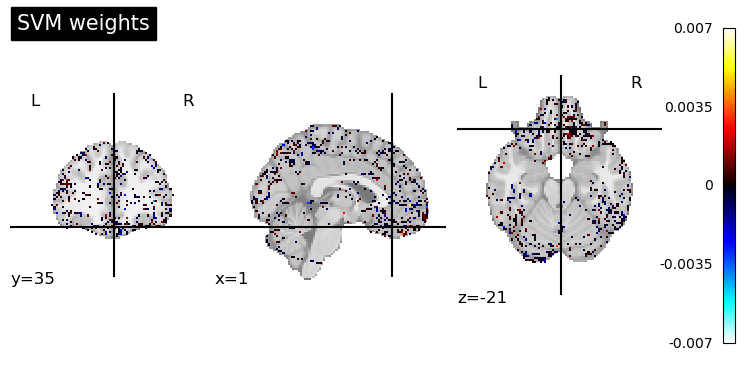

In [88]:
# Visualize the results
# ---------------------
# Look at the SVC's discriminating weights using
# :class:`nilearn.plotting.plot_stat_map`
weight_img = decoder.coef_img_["Wonder"]
from nilearn.plotting import plot_stat_map, show

plot_stat_map(weight_img, title="SVM weights")

show()

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



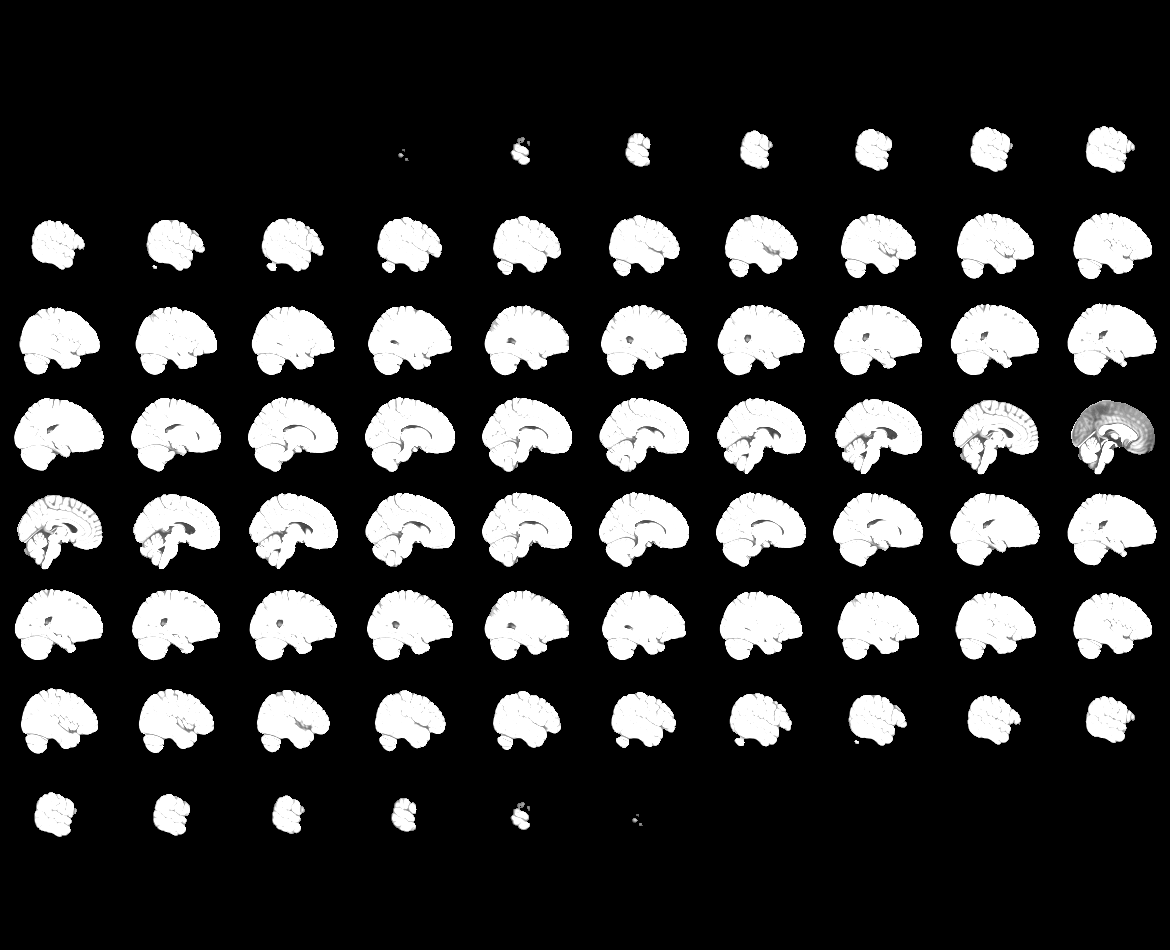
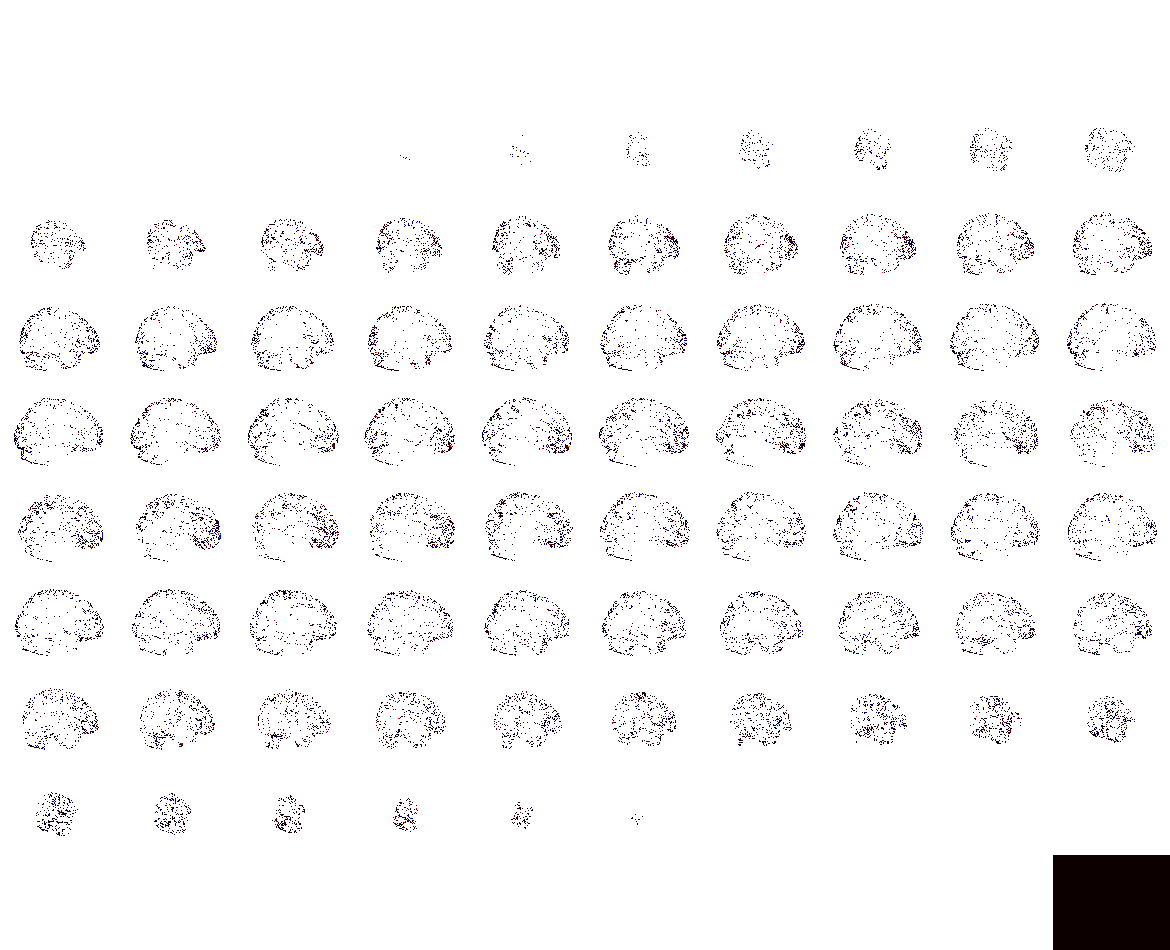

In [89]:
# Or we can plot the weights using :class:`nilearn.plotting.view_img` as a
# dynamic html viewer
from nilearn.plotting import view_img

view_img(weight_img, title="SVM weights", dim=-1)

In [90]:
# Saving the results as a Nifti file may also be important
# from pathlib import Path

# output_dir = Path.cwd() / "results" / "plot_haxby_anova_svm"
# output_dir.mkdir(exist_ok=True, parents=True)
# print(f"Output will be saved to: {output_dir}")
# weight_img.to_filename(output_dir / "haxby_face_vs_house.nii")

# sphinx_gallery_dummy_images=1
